# 2.3.2 k-nearest neighbor method
- 実はこの手法，訓練時にはなにもしない
- 新しいデータポイントに対する予測を行う際に，訓練データセットの中から一番近い点，つまり「最近傍点」を見つける
## 2.3.2.1 k-nearest neighbor method によるクラス分類
まずはforgeデータを用意します．

In [26]:
"""
仮想データ作成用関数
  mglearn.datasets.make_forge() 
  mglearn.datasets.make_() 
"""
import numbers
import numpy as np
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_

def make_forge():
    # a carefully hand-designed dataset lol
    #X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    random_state=4
    n_samples=30
    n_features=2
    centers=2
    generator = check_random_state(random_state)
    centers = generator.uniform(-10.0, 10.0, size=(centers, n_features))
    X = []
    y = []
    n_centers = centers.shape[0]
    
    n_samples_per_center = [int(n_samples // n_centers)] * n_centers
    cluster_std = np.ones(len(centers))
    for i in range(n_samples % n_centers):
        n_samples_per_center[i] += 1
    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std, size=(n, n_features)))
        y += [i] * n
    X = np.concatenate(X)
    y = np.array(y)
    X, y = shuffle_(X, y, random_state=generator)
    
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

In [27]:
#  図2-4 plot_knn_classificationの中身
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

# 近傍パラメータの設定 ここを1にしたり3にしたりする
n_neighbors = 1

# データのロード
X, y = make_forge()
# テストデータの作成
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])
dist = euclidean_distances(X, X_test)
closest = np.argsort(dist, axis=0)
for x, neighbors in zip(X_test, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], x[1], X[neighbor, 0] - x[0], X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')
# classifier の生成
clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)

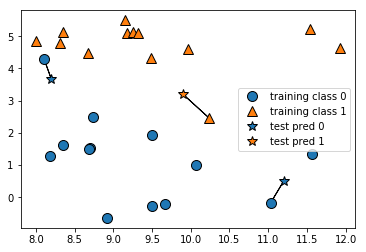

In [28]:
# 描画
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
ax = plt.gca()
markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10 
current_cycler = mpl.rcParams['axes.prop_cycle']
lines = []
# 元データのプロット
unique_y = np.unique(y)
labels = unique_y
for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
    mask = y == yy
    color = cycle['color'] # use color cycle
    if np.mean(colorConverter.to_rgb(color)) < .4:
        markeredgecolor = "grey"
    else:
        markeredgecolor = "black"
    lines.append(ax.plot(X[mask, 0], X[mask, 1], markers[i], markersize=10, label=labels[i], alpha=1, c=color,
                         markeredgecolor=markeredgecolor)[0])
# 新データのプロット
unique_y = np.unique(clf.predict(X_test))
labels = unique_y
markers = "*" * len(unique_y)
for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
    mask = clf.predict(X_test) == yy
    color = cycle['color'] # use color cycle
    if np.mean(colorConverter.to_rgb(color)) < .4:
        markeredgecolor = "grey"
    else:
        markeredgecolor = "black"
    lines.append(ax.plot(X_test[mask, 0], X_test[mask, 1], markers[i], markersize=10, label=labels[i], alpha=1, c=color,
                         markeredgecolor=markeredgecolor)[0])
# ここまで discrete_scatter
plt.legend(lines, ["training class 0", "training class 1", "test pred 0", "test pred 1"])
plt.show()

データを訓練セットとテストセットに分割し、汎化性能を評価できるようにしましょう

In [40]:
# データの用意
from sklearn.model_selection import train_test_split
X, y = make_forge() # 一応思い出す用
# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# K-NNでfit
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

# X_testに対してfit感を確認
clf.predict(X_test)

array([1, 0, 1, 0, 1, 0, 0])

In [41]:
clf.score(X_test, y_test)

0.8571428571428571

86点！

## 2.3.2.2KNeighborClassifierの解析
平面を、そこに点があったとしたら分類されていたであろうクラスに従って色付けしたときの，色の境目を決定境界といいます．決定境界を出してみましょう！

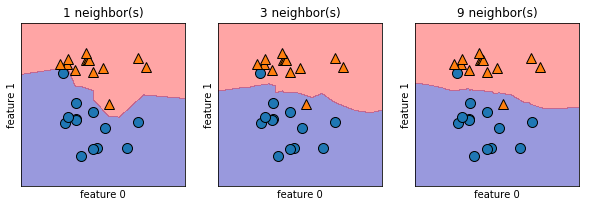

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])
for n_neighbors, ax in zip([1,3,9], axes):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)
    
    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = clf.predict_proba(X_grid)[:, 1]
    levels = [.5] 
    fill_levels = [0] + levels + [1]
    ax.contourf(X1, X2, decision_values.reshape(X1.shape), levels=fill_levels, alpha=.4, cmap=cm2)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    
    markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10
    current_cycler = mpl.rcParams['axes.prop_cycle']
    lines = []
    unique_y = np.unique(y)
    labels = unique_y
    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        color = cycle['color'] # use color cycle
        lines.append(ax.plot(X[mask, 0], X[mask, 1], markers[i], markersize=10, 
                             label=labels[i], alpha=1, c=color, markeredgecolor="black")[0])
    
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
plt.show()

- 1つの最近傍点のみを用いると、決定境界は、訓練データに近くなる
- より多くの最近傍点を考慮すると、決定境界はよりなめらかになる
- 最近傍点が少ない場合は複雑度の高いモデル
- 最近傍点が多い場合は複雑度の低いモデル

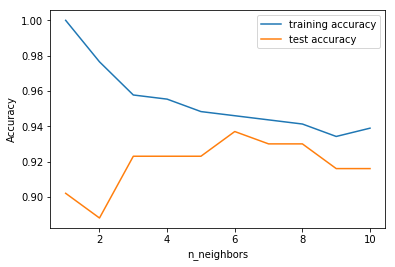

In [85]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=66)

training_accuracy = []
test_accuracy = []
# n_neighborsを1から10まで試す
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # モデルを構築
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # 訓練セット精度を記録
    training_accuracy.append(clf.score(X_train, y_train))
    # 汎化精度を記録
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

## 2.3.2.3 k-nearest neighbor regression

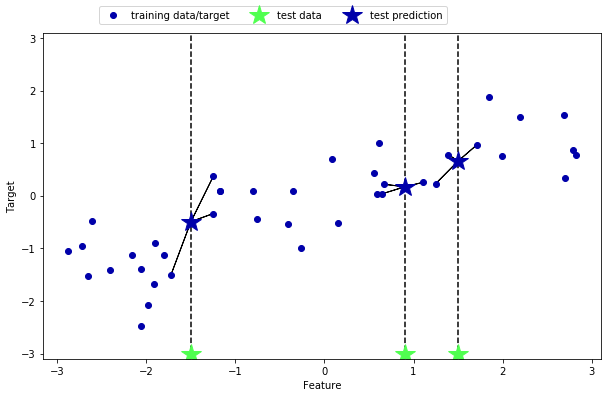

In [86]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import euclidean_distances
from matplotlib.colors import ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

# 近傍の数パラメータ
n_neighbors = 3

X, y = make_wave(n_samples=40)
X_test = np.array([[-1.5], [0.9], [1.5]])

dist = euclidean_distances(X, X_test)
closest = np.argsort(dist, axis=0)

plt.figure(figsize=(10, 6))

reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, y)
y_pred = reg.predict(X_test)

for x, y_, neighbors in zip(X_test, y_pred, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], y_, X[neighbor, 0] - x[0], y[neighbor] - y_, head_width=0, fc='k', ec='k')

train, = plt.plot(X, y, 'o', c=cm3(0))
test, = plt.plot(X_test, -3 * np.ones(len(X_test)), '*', c=cm3(2), markersize=20)
pred, = plt.plot(X_test, y_pred, '*', c=cm3(0), markersize=20)
plt.vlines(X_test, -3.1, 3.1, linestyle="--")
plt.legend([train, test, pred], ["training data/target", "test data", "test prediction"], ncol=3, loc=(.1, 1.025))
plt.ylim(-3.1, 3.1)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

In [92]:
from sklearn.neighbors import KNeighborsRegressor
X, y = make_wave(n_samples=40)
# waveデータセットを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 3つの最近傍点を考慮するように設定してモデルのインスタンスを生成
reg = KNeighborsRegressor(n_neighbors=3)
# 訓練データと訓練ターゲットを用いてモデルを学習させる
reg.fit(X_train, y_train)
reg.predict(X_test)

array([-0.05396539,  0.35686046,  1.13671923, -1.89415682, -1.13881398,
       -1.63113382,  0.35686046,  0.91241374, -0.44680446, -1.13881398])

In [93]:
reg.score(X_test, y_test)

0.83441724462496036

## 2.3.2.4 KNeighborsRegressorの解析

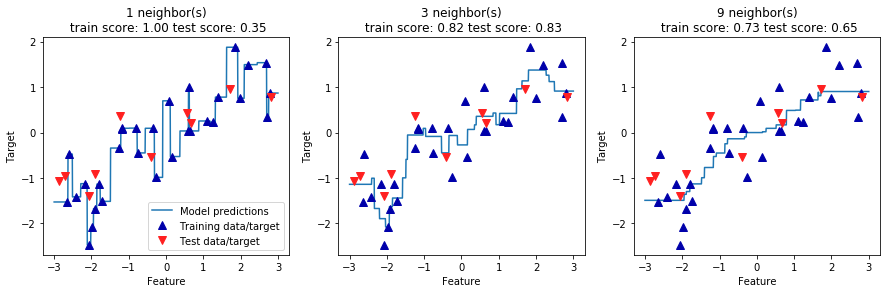

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# -3から3までの間に1,000点のデータポイントを作る
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # 1, 3, 9 近傍点で予測
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=cm2(1), markersize=8)
    ax.set_title("{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(n_neighbors, 
                                                                                  reg.score(X_train, y_train),reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
    axes[0].legend(["Model predictions", "Training data/target", "Test data/target"], loc="best")
plt.show()

## 2.3.2.5　利点と欠点とパラメータ
- KNeighbors分類器には2つの重要なパラメータ
    - 近傍点の数 → パラメータは調整
    - データポイント間の距離測度 → ほとんどの場合ユークリッド距離でOK
- k-最近傍法の利点
    - 理解しやすさ
    - 多くの場合あまり調整しなくても十分に高い性能
    - ベースラインとして試してみるのに良いモデル
    - モデル構築は非常に高速 ⇔ 予測は遅い
- k-最近傍法の欠点
    - 多数の特徴量（数百以上）を持つデータセットではうまく機能しない
    - 特徴量が多くの場合0となるような疎なデータセット（sparse dataset）では特に性能が悪い
    - 予測時の処理速度が遅く，多数の特徴量を扱うことができない